In [56]:
import numpy as np
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

from lime.lime_text import LimeTextExplainer

In [57]:
df = pd.read_csv("data.csv")
print("Initial Dataset:")
print(df.head())

Initial Dataset:
   index                      title    genre  \
0      0          Drowned Wednesday  fantasy   
1      1              The Lost Hero  fantasy   
2      2  The Eyes of the Overworld  fantasy   
3      3            Magic's Promise  fantasy   
4      4             Taran Wanderer  fantasy   

                                             summary  
0   Drowned Wednesday is the first Trustee among ...  
1   As the book opens, Jason awakens on a school ...  
2   Cugel is easily persuaded by the merchant Fia...  
3   The book opens with Herald-Mage Vanyel return...  
4   Taran and Gurgi have returned to Caer Dallben...  


In [58]:
# Drop the 'index' column
df = df.drop(columns=['index'])
print("\nAfter Dropping 'index' Column:")
print(df.head())


After Dropping 'index' Column:
                       title    genre  \
0          Drowned Wednesday  fantasy   
1              The Lost Hero  fantasy   
2  The Eyes of the Overworld  fantasy   
3            Magic's Promise  fantasy   
4             Taran Wanderer  fantasy   

                                             summary  
0   Drowned Wednesday is the first Trustee among ...  
1   As the book opens, Jason awakens on a school ...  
2   Cugel is easily persuaded by the merchant Fia...  
3   The book opens with Herald-Mage Vanyel return...  
4   Taran and Gurgi have returned to Caer Dallben...  


In [59]:

df['genre'] = df['genre'].astype('category')
df['genre_label'] = df['genre'].cat.codes
genre_mapping = dict(enumerate(df['genre'].cat.categories))
print("\nGenre to Label Mapping:")
print(genre_mapping)


Genre to Label Mapping:
{0: 'crime', 1: 'fantasy', 2: 'history', 3: 'horror', 4: 'psychology', 5: 'romance', 6: 'science', 7: 'sports', 8: 'thriller', 9: 'travel'}


In [60]:
nltk.download('wordnet')
nltk.download('stopwords')
lemmatizer = nltk.stem.WordNetLemmatizer()
stopwords = nltk.corpus.stopwords.words('english')

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stopwords])
    return text

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dharm\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dharm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [61]:

df['summary'] = df['summary'].apply(preprocess_text)
print("""\nAfter Text Preprocessing (stopwords, punctuation, URLs and lemmatization are removed):
      example: "This is a great movie about a young hero's adventure! Visit http://example.com for more info."
      becomes: "great movie young hero adventure" \n""")  
print(df.head())


After Text Preprocessing (stopwords, punctuation, URLs and lemmatization are removed):
      example: "This is a great movie about a young hero's adventure! Visit http://example.com for more info."
      becomes: "great movie young hero adventure" 

                       title    genre  \
0          Drowned Wednesday  fantasy   
1              The Lost Hero  fantasy   
2  The Eyes of the Overworld  fantasy   
3            Magic's Promise  fantasy   
4             Taran Wanderer  fantasy   

                                             summary  genre_label  
0  drowned wednesday first trustee among morrow d...            1  
1  book open jason awakens school bus unable reme...            1  
2  cugel easily persuaded merchant fianosther att...            1  
3  book open heraldmage vanyel returning country ...            1  
4  taran gurgi returned caer dallben following ev...            1  


C:\Users\dharm\AppData\Local\Temp\ipykernel_20504\816816063.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df['genre'].value_counts().index, y=df['genre'].value_counts().values, palette="viridis")


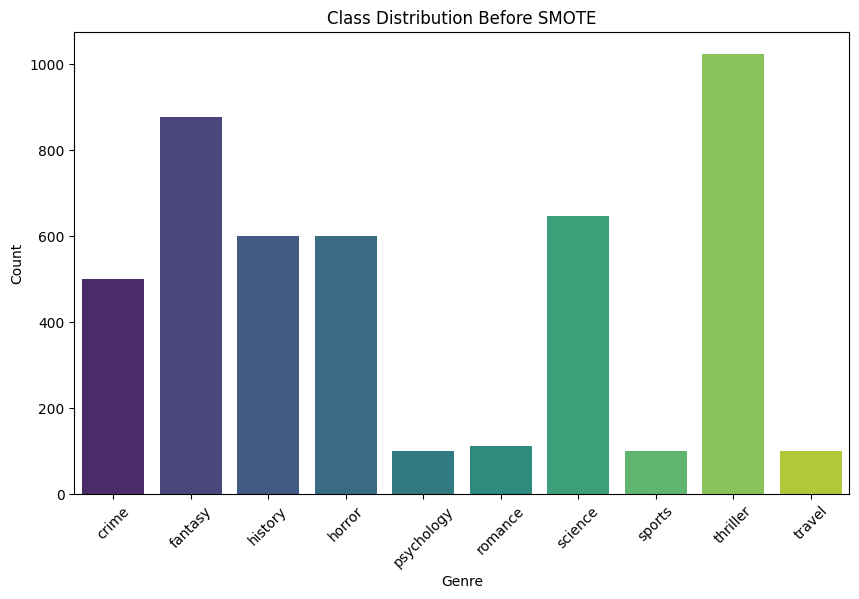

In [62]:
plt.figure(figsize=(10, 6))
sns.barplot(x=df['genre'].value_counts().index, y=df['genre'].value_counts().values, palette="viridis")
plt.title("Class Distribution Before SMOTE")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

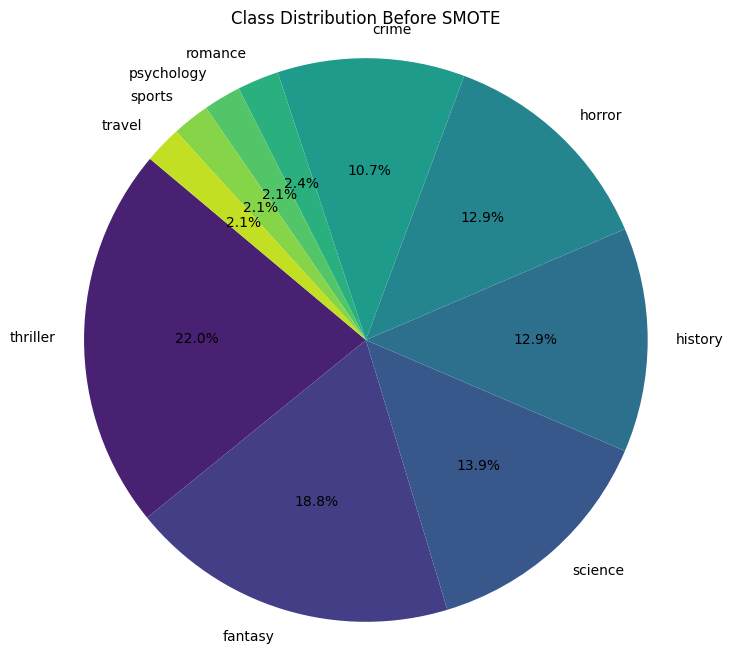

In [63]:
plt.figure(figsize=(8, 8))
genre_counts_before = df['genre'].value_counts()
plt.pie(
    genre_counts_before,
    labels=genre_counts_before.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette("viridis", len(genre_counts_before))
)
plt.title('Class Distribution Before SMOTE')
plt.axis('equal')
plt.show()


In [64]:
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2)) # unigram, bigrams
X = tfidf.fit_transform(df['summary'])
y = df['genre_label']

In [65]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

C:\Users\dharm\AppData\Local\Temp\ipykernel_20504\2799061175.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pd.Series(y_resampled).value_counts().index, y=pd.Series(y_resampled).value_counts().values, palette="viridis")


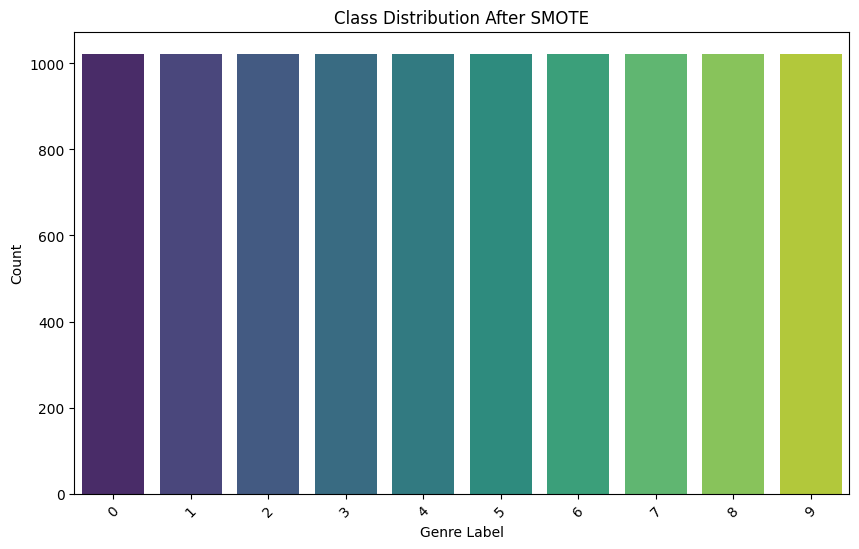

In [66]:
plt.figure(figsize=(10, 6))
sns.barplot(x=pd.Series(y_resampled).value_counts().index, y=pd.Series(y_resampled).value_counts().values, palette="viridis")
plt.title("Class Distribution After SMOTE")
plt.xlabel("Genre Label")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

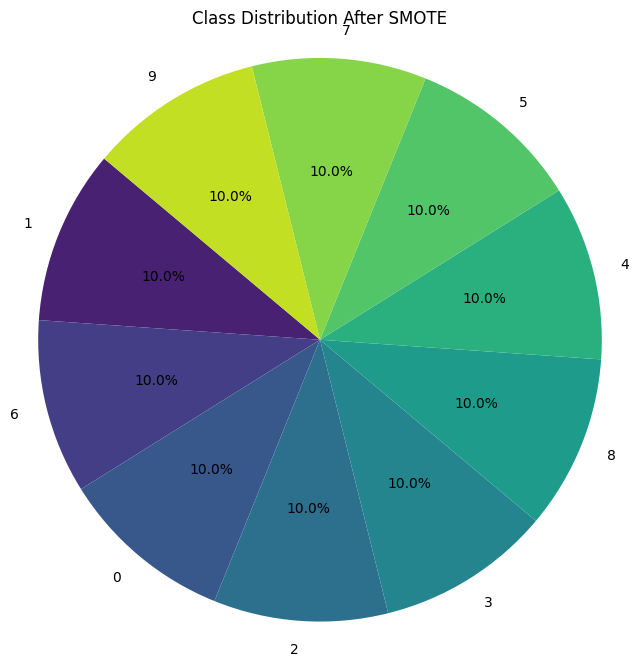

In [67]:
# Pie chart after SMOTE
plt.figure(figsize=(8, 8))
genre_counts_after = pd.Series(y_resampled).value_counts()
plt.pie(
    genre_counts_after,
    labels=genre_counts_after.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette("viridis", len(genre_counts_after))
)
plt.title('Class Distribution After SMOTE')
plt.axis('equal')
plt.show()

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [69]:

lr_model = LogisticRegression(class_weight='balanced', max_iter=1000)
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1) #n_jobs=-1 for parallel processing cpu power.
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)


In [70]:
# Ensemble Model + Voting.
ensemble_model = VotingClassifier(estimators=[
    ('lr', lr_model),
    ('rf', rf_model),
    ('gb', gb_model)
], voting='soft')

In [71]:
# before SMOTE
X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(X, y, test_size=0.2, random_state=42)
ensemble_model.fit(X_train_original, y_train_original)
y_pred_original = ensemble_model.predict(X_test_original)
report_original = classification_report(y_test_original, y_pred_original, output_dict=True)

In [72]:
# after SMOTE
ensemble_model.fit(X_train, y_train)

y_pred_resampled = ensemble_model.predict(X_test)
report_resampled = classification_report(y_test, y_pred_resampled, output_dict=True)

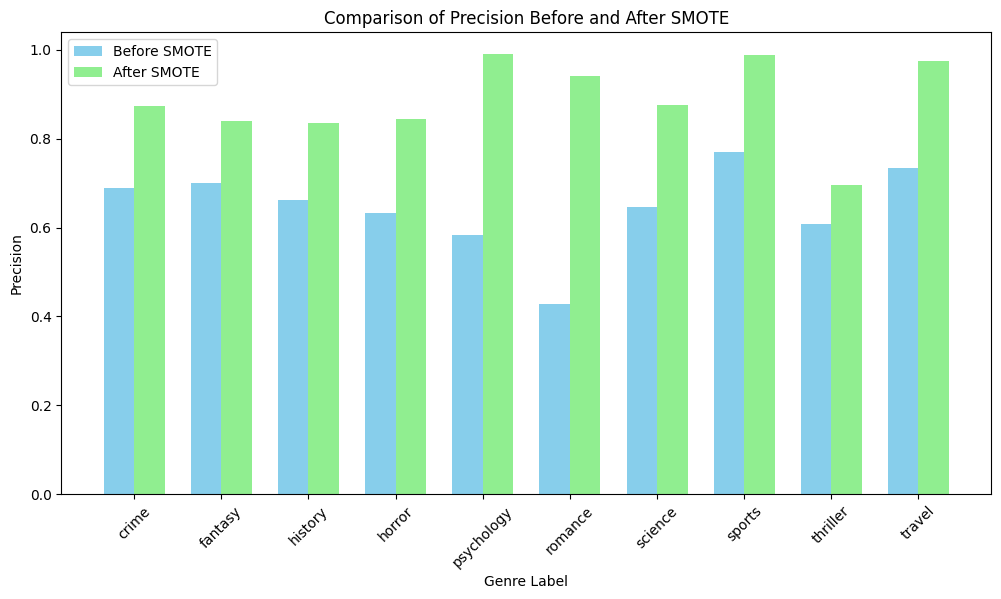

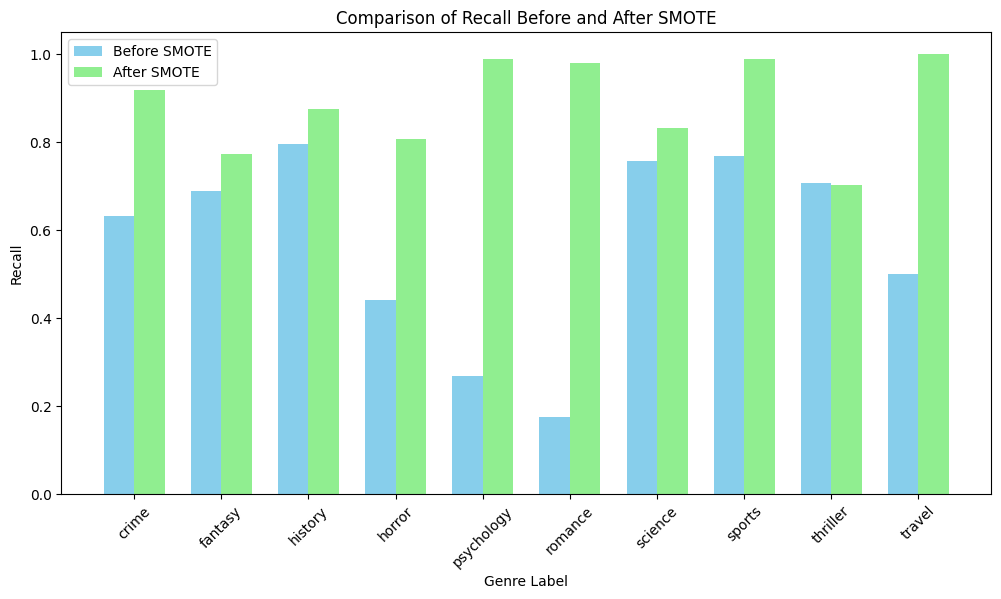

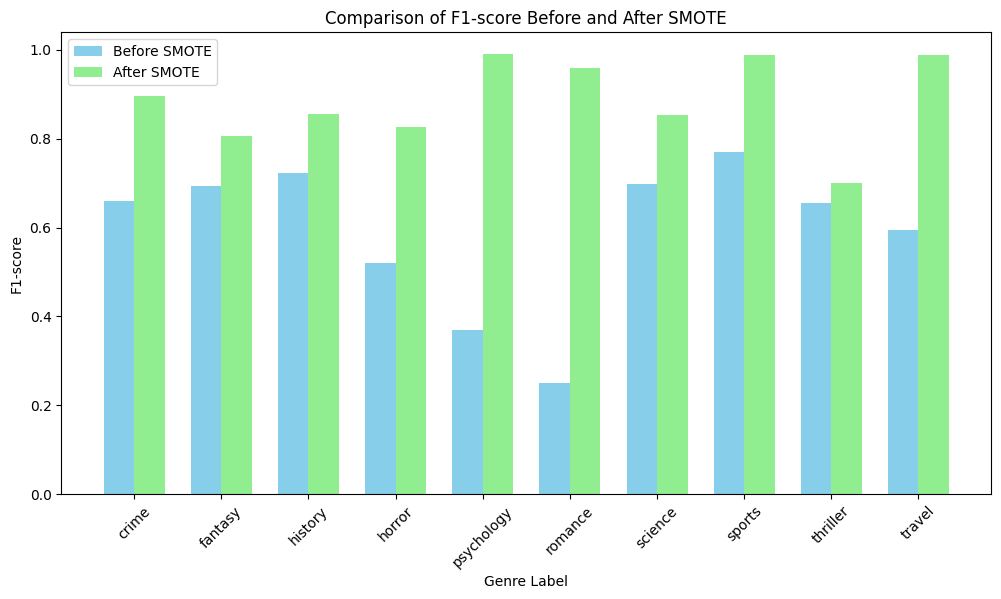

In [73]:
metrics = ['precision', 'recall', 'f1-score']
labels = list(genre_mapping.values())

for metric in metrics:
    before = [report_original[str(i)][metric] for i in range(len(labels))]
    after = [report_resampled[str(i)][metric] for i in range(len(labels))]

    plt.figure(figsize=(12, 6))
    bar_width = 0.35
    index = np.arange(len(labels))

    plt.bar(index, before, bar_width, label='Before SMOTE', color='skyblue')
    plt.bar(index + bar_width, after, bar_width, label='After SMOTE', color='lightgreen')

    plt.xlabel('Genre Label')
    plt.ylabel(metric.capitalize())
    plt.title(f'Comparison of {metric.capitalize()} Before and After SMOTE')
    plt.xticks(index + bar_width / 2, labels, rotation=45)
    plt.legend()
    plt.show()

In [74]:
# Display classification reports
print("Classification Report Before SMOTE:")
print(classification_report(y_test_original, y_pred_original))

print("\nClassification Report After SMOTE:")
print(classification_report(y_test, y_pred_resampled))

Classification Report Before SMOTE:
              precision    recall  f1-score   support

           0       0.69      0.63      0.66       109
           1       0.70      0.69      0.69       196
           2       0.66      0.80      0.72       118
           3       0.63      0.44      0.52       113
           4       0.58      0.27      0.37        26
           5       0.43      0.18      0.25        17
           6       0.65      0.76      0.70       120
           7       0.77      0.77      0.77        13
           8       0.61      0.71      0.65       198
           9       0.73      0.50      0.59        22

    accuracy                           0.65       932
   macro avg       0.65      0.57      0.59       932
weighted avg       0.65      0.65      0.65       932


Classification Report After SMOTE:
              precision    recall  f1-score   support

           0       0.87      0.92      0.90       211
           1       0.84      0.77      0.80       211
      

In [75]:
# Create a wrapper function for LIME that takes raw text as input
class GenrePredictor:
    def __init__(self, vectorizer, model, label_mapping):
        self.vectorizer = vectorizer
        self.model = model
        self.label_mapping = label_mapping
        self.class_names = [label_mapping[i] for i in range(len(label_mapping))]
    
    def predict_proba(self, texts): #Transforms raw text using the same TF-IDF vectorizer.
        # This method is needed by LIME
        vectorized_texts = self.vectorizer.transform(texts)
        return self.model.predict_proba(vectorized_texts)
    
    def preprocess_and_predict(self, raw_text): #Applies the same preprocessing (preprocess_text()).
        """Preprocess and predict a single text"""
        # Preprocess
        processed_text = preprocess_text(raw_text)
        
        # Transform
        text_vector = self.vectorizer.transform([processed_text])
        
        # Predict
        predicted_label = self.model.predict(text_vector)[0]
        predicted_probs = self.model.predict_proba(text_vector)[0]
        predicted_genre = self.label_mapping[predicted_label]
        
        return {
            'processed_text': processed_text,
            'predicted_label': predicted_label,
            'predicted_genre': predicted_genre,
            'prediction_probabilities': predicted_probs
        }


===== EXPLAINABLE AI USING LIME =====

===== Example 1 =====

Original Text: In a small coastal town, a writer meets an artist at a local gallery. Despite their differences, the two quickly form a deep bond, sharing dreams and exploring the hidden beauty of the seaside. As the seasons change, their relationship blossoms into a timeless love story.
Processed Text: small coastal town writer meet artist local gallery despite difference two quickly form deep bond sharing dream exploring hidden beauty seaside season change relationship blossom timeless love story
Predicted Genre: thriller (Label 8)

Confidence Scores:
  thriller: 0.1503
  fantasy: 0.1445
  horror: 0.1246
  travel: 0.1231
  history: 0.1209
  romance: 0.1091
  crime: 0.0860
  science: 0.0652
  psychology: 0.0483
  sports: 0.0281

Explanation for the prediction:


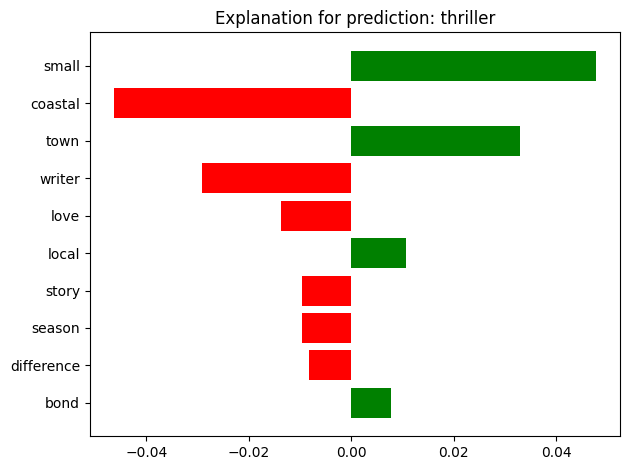


Top features contributing to the prediction:
  + small: 0.0477 (supports thriller)
  - coastal: -0.0463 (contradicts thriller)
  + town: 0.0329 (supports thriller)
  - writer: -0.0291 (contradicts thriller)
  - love: -0.0136 (contradicts thriller)
  + local: 0.0106 (supports thriller)
  - story: -0.0096 (contradicts thriller)
  - season: -0.0096 (contradicts thriller)
  - difference: -0.0082 (contradicts thriller)
  + bond: 0.0077 (supports thriller)


In [76]:
# Initialize the predictor and LIME explainer
predictor = GenrePredictor(tfidf, ensemble_model, genre_mapping)
explainer = LimeTextExplainer(class_names=predictor.class_names)

# Function to explain predictions
def explain_prediction(text, num_features=10):
    # Preprocess and predict
    result = predictor.preprocess_and_predict(text)
    processed_text = result['processed_text']
    predicted_label = result['predicted_label']
    predicted_genre = result['predicted_genre']
    probabilities = result['prediction_probabilities']
    
    # Create explanation
    explanation = explainer.explain_instance(
        processed_text, 
        predictor.predict_proba, 
        num_features=num_features, 
        top_labels=1
    )
    
    # Print prediction results
    print(f"\nOriginal Text: {text}")
    print(f"Processed Text: {processed_text}")
    print(f"Predicted Genre: {predicted_genre} (Label {predicted_label})")
    
    # Print confidence scores for all genres in descending order
    print("\nConfidence Scores:")
    sorted_probs = sorted(enumerate(probabilities), key=lambda x: x[1], reverse=True)

    for i, prob in sorted_probs:
        print(f"  {genre_mapping[i]}: {prob:.4f}")

    
    # Visualize the explanation
    print("\nExplanation for the prediction:")
    explanation.as_pyplot_figure(label=predicted_label)
    plt.title(f'Explanation for prediction: {predicted_genre}')
    plt.tight_layout()
    plt.show()
    
    # Print the most important words
    print("\nTop features contributing to the prediction:")
    for word, score in explanation.as_list(label=predicted_label):
        if score > 0:
            print(f"  + {word}: {score:.4f} (supports {predicted_genre})")
        else:
            print(f"  - {word}: {score:.4f} (contradicts {predicted_genre})")
    
    return explanation

# Test the explanation function with some example stories
example_stories = [
    # "In a distant kingdom, a young warrior discovers a hidden map leading to an ancient treasure guarded by a fierce dragon. With courage and a magical sword, the warrior sets out on an epic quest, facing mythical creatures and dark sorcery along the way.",
    # "In the year 2150, Earth's last colony on Mars faces a mysterious energy surge that disrupts all communication. A group of astronauts must travel beyond the known galaxy to uncover the source of the anomaly, encountering advanced alien technology that challenges the laws of physics.",
    "In a small coastal town, a writer meets an artist at a local gallery. Despite their differences, the two quickly form a deep bond, sharing dreams and exploring the hidden beauty of the seaside. As the seasons change, their relationship blossoms into a timeless love story.",
    # "Detective Harris receives a call about a missing person who disappeared without a trace from a locked room. As she delves deeper into the case, she uncovers a web of lies and a secret that ties the victim to a powerful criminal organization. The closer she gets to the truth, the more dangerous it becomes."
]

# Explain each example story
print("\n===== EXPLAINABLE AI USING LIME =====")
for i, story in enumerate(example_stories):
    print(f"\n===== Example {i+1} =====")
    explain_prediction(story)

In [77]:
import joblib

# Save model and vectorizer
joblib.dump(ensemble_model, "saved_model.pkl")
joblib.dump(tfidf, "saved_vectorizer.pkl")


['saved_vectorizer.pkl']

# For now IGNORE

In [29]:

user_inputs = [
    "In a distant kingdom, a young warrior discovers a hidden map leading to an ancient treasure guarded by a fierce dragon. With courage and a magical sword, the warrior sets out on an epic quest, facing mythical creatures and dark sorcery along the way.",
    "In the year 2150, Earth’s last colony on Mars faces a mysterious energy surge that disrupts all communication. A group of astronauts must travel beyond the known galaxy to uncover the source of the anomaly, encountering advanced alien technology that challenges the laws of physics.",
    "In a small coastal town, a writer meets an artist at a local gallery. Despite their differences, the two quickly form a deep bond, sharing dreams and exploring the hidden beauty of the seaside. As the seasons change, their relationship blossoms into a timeless love story.",
    "Detective Harris receives a call about a missing person who disappeared without a trace from a locked room. As she delves deeper into the case, she uncovers a web of lies and a secret that ties the victim to a powerful criminal organization. The closer she gets to the truth, the more dangerous it becomes."
]

def preprocess_user_input(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stopwords])
    return text

for i, user_input in enumerate(user_inputs):
    processed_input = preprocess_user_input(user_input)

    input_vector = tfidf.transform([processed_input])

    # Get predicted probabilities for all genres
    proba = ensemble_model.predict_proba(input_vector)[0]

    # Get indices of top 2 genres
    top_indices = np.argsort(proba)[-1:][::-1]  # descending order

    # Map to genre names and show confidence
    top_genres = [(genre_mapping[i], proba[i]) for i in top_indices]

    print(f"\nOriginal Story: {user_input}")
    print(f"Processed Story: {processed_input}")
    print("Top 2 Predicted Genres:")
    for genre, score in top_genres:
        print(f"• {genre} ({score:.2%} confidence)")


Original Story: In a distant kingdom, a young warrior discovers a hidden map leading to an ancient treasure guarded by a fierce dragon. With courage and a magical sword, the warrior sets out on an epic quest, facing mythical creatures and dark sorcery along the way.
Processed Story: distant kingdom young warrior discovers hidden map leading ancient treasure guarded fierce dragon courage magical sword warrior set epic quest facing mythical creature dark sorcery along way
Top 2 Predicted Genres:
• fantasy (83.81% confidence)

Original Story: In the year 2150, Earth’s last colony on Mars faces a mysterious energy surge that disrupts all communication. A group of astronauts must travel beyond the known galaxy to uncover the source of the anomaly, encountering advanced alien technology that challenges the laws of physics.
Processed Story: year 2150 earth last colony mar face mysterious energy surge disrupts communication group astronaut must travel beyond known galaxy uncover source anomal